In [3]:
#dependencies
import requests
import pandas as pd
import numpy as np
import json
import time
import matplotlib.pyplot as plt
from scipy.stats import linregress
from config import api_key
import seaborn as sns
season = 2022

In [4]:
#get team ids
team_url = f'http://api.sportradar.us/nba/trial/v8/en/seasons/{season}/REG/standings.json?api_key={api_key}'

team_data = requests.get(team_url).json()
def extract_team_data(data):
    teams = []
    if 'teams' in data:
        for team in data['teams']:
            team_id = team['id']
            team_name = team['name']
            teams.append({'id': team_id, 'name': team_name})
    if 'divisions' in data:
        for division in data['divisions']:
            teams += extract_team_data(division)
    if 'conferences' in data:
        for conference in data['conferences']:
            teams += extract_team_data(conference)
    return teams

# Extract team id and team name from the team_data dictionary
teams = extract_team_data(team_data)
teams_info=pd.DataFrame(teams)
teams_id= teams_info["id"]
time.sleep(1)

In [5]:
# Initialize
#team lists
team_name=[]
team_possession=[]
team_assists=[]
team_field_goals=[]
team_id=[]
team_data={}
team_offensive_rebounds=[]
team_turnovers=[]
team_free_throws_att=[]
opp_possession=[]
possession=[]
team_o_rtg=[]
team_d_rtg=[]
team_net_rtg=[]
field_goals_made=[]
three_points_att=[]
three_points_made=[]
free_throws_made=[]
ow_defensive_rebounds=[]
ow_points=[]

#opponent vs team lists
opp_points=[]
opp_defensive_rebounds=[]
opp_offensive_rebounds=[]
opp_field_goals_made=[]
opp_three_points_made=[]
opp_free_throws_made=[]
opp_free_throws_att=[]
opp_field_goals_att=[]
opp_three_points_att=[]
opp_turnovers=[]
i=0
# Loop through each team ID and retrieve their statistics from the API
for i in range(len(teams_id)):
    team_url = f'http://api.sportradar.us/nba/trial/v8/en/seasons/{season}/REG/teams/{teams_id[i]}/statistics.json?api_key={api_key}'
    team_data = requests.get(team_url).json()
    # Extract various statistics for the each team
    field_goals_att=team_data['own_record']['total']['field_goals_att']
    makes=team_data['own_record']['total']['field_goals_made']
    offensive_rebounds=team_data['own_record']['total']['offensive_rebounds']
    defensive_rebounds=team_data['own_record']['total']['defensive_rebounds']
    ft_att=team_data['own_record']['total']['free_throws_att']
    turnovers=team_data['own_record']['total']['turnovers']
    free_throws_att=team_data['own_record']['total']['free_throws_att']
    points=team_data['own_record']['total']['points']
    
    offensive_rebounds_opp=team_data['opponents']['total']['offensive_rebounds']
    defensive_rebounds_opp=team_data['opponents']['total']['defensive_rebounds']
    field_goals_att_opp=team_data['opponents']['total']['field_goals_att']
    makes_opp=team_data['opponents']['total']['field_goals_made']
    ft_att_opp=team_data['opponents']['total']['free_throws_att']
    turnovers_opp=team_data['opponents']['total']['turnovers']
    points_opp=team_data['opponents']['total']['points']

    team_totals_dict = team_data['own_record']['total']
    opp_vs_team_totals_dict = team_data['opponents']['total']

    team_stat_keys = ['games_played', 'minutes', 'field_goals_made', 'field_goals_att',
                      'three_points_made', 'three_points_att', 'three_points_pct',
                      'free_throws_made', 'free_throws_att', 'offensive_rebounds',
                      'defensive_rebounds', 'rebounds', 'assists', 'turnovers',
                      'steals', 'blocks', 'points']
    team_stats = {k: v for k, v in team_totals_dict.items() if k in team_stat_keys}
    opp_vs_team_stats = {k: v for k, v in opp_vs_team_totals_dict.items() if k in team_stat_keys}

    #team stats calculations
    #new possession formula
    team_poss = field_goals_att + (0.4 * ft_att) - (1.07 * ((offensive_rebounds) / (offensive_rebounds + defensive_rebounds_opp)) * (field_goals_att - makes)) + (turnovers)
    opp_possession = field_goals_att_opp + (0.4 * ft_att_opp) - (1.07 * ((offensive_rebounds_opp) / (offensive_rebounds_opp + defensive_rebounds)) * (field_goals_att_opp - makes_opp)) + (turnovers_opp)
    possession = (team_poss + opp_possession) / 2
    
    o_rtg = 100 * (points) / (possession)
    d_rtg = 100 * (points_opp) / (possession)
    net_rtg = (o_rtg) - (d_rtg)

    #Append the extracted statistics to teams' lists
    team_name.append(team_data['name'])
    team_id.append(team_data['id']) 
    team_field_goals.append(field_goals_att)
    field_goals_made.append(team_stats["field_goals_made"])
    team_assists.append(team_stats['assists'])
    team_offensive_rebounds.append(offensive_rebounds)
    team_turnovers.append(turnovers)
    team_free_throws_att.append(free_throws_att)
    team_possession.append(possession)
    team_o_rtg.append(o_rtg)
    team_d_rtg.append(d_rtg)
    team_net_rtg.append(net_rtg)
    three_points_att.append(team_stats['three_points_att'])
    three_points_made.append(team_stats["three_points_made"])
    free_throws_made.append(team_stats["free_throws_made"])
    ow_defensive_rebounds.append(team_stats["defensive_rebounds"])
    ow_points.append(team_stats['points'])

    #opponents vs
    opp_offensive_rebounds.append(opp_vs_team_stats['offensive_rebounds'])
    opp_defensive_rebounds.append(opp_vs_team_stats["defensive_rebounds"])
    opp_points.append(opp_vs_team_stats['points'])
    opp_field_goals_att.append(opp_vs_team_stats['field_goals_att'])
    opp_field_goals_made.append(opp_vs_team_stats['field_goals_made'])
    opp_three_points_att.append(opp_vs_team_stats['three_points_att'])
    opp_three_points_made.append(opp_vs_team_stats['three_points_made'])
    opp_free_throws_att.append(opp_vs_team_stats['free_throws_att'])
    opp_free_throws_made.append(opp_vs_team_stats['free_throws_made'])
    opp_turnovers.append(opp_vs_team_stats['turnovers'])
    


    # Pause execution for 0.5 second to avoid overloading the API
    time.sleep(1)

# Create Teams DataFrame
teams_df=pd.DataFrame({
    'Team Name' : team_name,
    'Team Possession': team_possession,
    'team_o_rtg': team_o_rtg,
    'team_d_rtg': team_d_rtg,
    'team_net_rtg': team_net_rtg,
    #team   
    'Team Field Goals Attempts':team_field_goals,
    'Team Field Goals Made':field_goals_made,
    'Team Assists': team_assists,
    'Team Offensive Rebounds': team_offensive_rebounds,
    'Team Defensive Rebounds': ow_defensive_rebounds,
    'Team Turnovers': team_turnovers,
    'Team Free throws Attempts': team_free_throws_att,
    'Team Free throws Made': free_throws_made,
    'Team Three Points Attempts': three_points_att,
    'Team Three Points Made':three_points_made,
    'Team Points': ow_points,

    #opponents
    'Opp Points': opp_points,
    'Opp Defensive Rebounds': opp_defensive_rebounds,
    'Opp Offensive Rebounds': opp_offensive_rebounds,
    'Opp Turnovers': opp_turnovers,
    'Opp Field Goals Attempts': opp_field_goals_att,
    'Opp Field Goals Made': opp_field_goals_made,
    'Opp Free throws Attempts': opp_free_throws_att,
    'Opp Free throws Made': opp_free_throws_made,
    'Opp Three Points Attempts': opp_three_points_att,
    'Opp Three Points Made': opp_three_points_made
   

})
teams_df

,Team Name,Team Possession,team_o_rtg,team_d_rtg,team_net_rtg,Team Field Goals Attempts,Team Field Goals Made,Team Assists,Team Offensive Rebounds,Team Defensive Rebounds,...,Opp Points,Opp Defensive Rebounds,Opp Offensive Rebounds,Opp Turnovers,Opp Field Goals Attempts,Opp Field Goals Made,Opp Free throws Attempts,Opp Free throws Made,Opp Three Points Attempts,Opp Three Points Made
0,Grizzlies,8273.612677,115.874412,111.970434,3.903978,7551,3585,2135,988,2835,...,9264,2738,902,1182,7365,3340,1931,1519,2998,1065
1,Pelicans,8144.766980,115.141416,113.238353,1.903062,7180,3447,2122,866,2717,...,9223,2634,792,1175,7105,3357,1935,1507,2953,1002
2,Mavericks,7967.625991,117.550698,117.475394,0.075305,6909,3283,1880,625,2556,...,9360,2838,830,1018,7065,3425,2046,1597,2596,913
3,Rockets,8093.666948,112.198835,120.155673,-7.956838,7287,3329,1835,1100,2695,...,9725,2543,861,1031,7226,3480,1986,1576,3183,1189
4,Spurs,8357.205521,110.910279,120.758069,-9.847789,7593,3533,2232,965,2619,...,10092,2811,877,1079,7460,3780,1942,1496,2651,1036
5,Kings,8249.519420,119.982747,117.352291,2.630456,7232,3573,2237,782,2699,...,9681,2665,795,1117,7288,3589,1882,1481,2740,1022
6,Suns,8033.179570,116.006370,113.890147,2.116223,7388,3453,2235,971,2657,...,9149,2676,840,1115,7044,3280,2101,1651,2628,938
7,Clippers,8041.745908,115.820620,115.310781,0.509840,7059,3370,1959,803,2742,...,9273,2699,838,1014,7243,3430,1832,1413,2738,1000
8,Warriors,8341.936947,116.915293,115.141124,1.774168,7393,3538,2446,864,2793,...,9605,2673,880,1111,7423,3478,2067,1589,2915,1060
9,Lakers,8344.505235,115.141638,114.578393,0.563245,7298,3516,2072,818,2930,...,9561,2770,908,992,7698,3607,1706,1319,2991,1028


In [6]:
#get standings and wins
standing_url = f'http://api.sportradar.us/nba/trial/v8/en/seasons/{season}/REG/standings.json?api_key={api_key}'
standing_data = requests.get(standing_url).json()
aa= standing_data["conferences"]
Teams_name=[]
standing_rank=[]
conferences2=[]
win=[]
n=i=j=0

for n in range(len(aa)):
    zz= standing_data["conferences"][n]['divisions']
    
    
    for i in range(len(zz)):
        bb=standing_data["conferences"][n]['divisions'][i]['teams']
        

        for j in range(len(bb)):
            Teams_name.append(standing_data["conferences"][n]['divisions'][i]['teams'][j]['name'])
            standing_rank.append(standing_data["conferences"][n]['divisions'][i]['teams'][j]['calc_rank']['conf_rank'])
            win.append(standing_data["conferences"][n]['divisions'][i]['teams'][j]['wins'])
            conferences2.append(standing_data["conferences"][n]['alias'])
    #b=pd.DataFrame[b]
    standing_df=pd.DataFrame({"Team Name": Teams_name,
                'Wins': win,
                'Conference Ranking': standing_rank,
                'Conferences':conferences2

   })
standing_df

#b5
last_team_df=pd.merge(standing_df,teams_df,on="Team Name")
last_team_df=last_team_df.sort_values('Conference Ranking')
last_team_df

,Team Name,Wins,Conference Ranking,Conferences,Team Possession,team_o_rtg,team_d_rtg,team_net_rtg,Team Field Goals Attempts,Team Field Goals Made,...,Opp Points,Opp Defensive Rebounds,Opp Offensive Rebounds,Opp Turnovers,Opp Field Goals Attempts,Opp Field Goals Made,Opp Free throws Attempts,Opp Free throws Made,Opp Three Points Attempts,Opp Three Points Made
10,Nuggets,53,1,WESTERN,8025.155235,118.315468,114.913665,3.401803,7088,3574,...,9222,2516,832,1059,7166,3423,1861,1443,2711,933
15,Bucks,58,1,EASTERN,8260.914931,116.076731,112.469382,3.607349,7411,3504,...,9291,2744,879,942,7644,3483,1719,1334,2799,991
0,Grizzlies,51,2,WESTERN,8273.612677,115.874412,111.970434,3.903978,7551,3585,...,9264,2738,902,1182,7365,3340,1931,1519,2998,1065
25,Celtics,57,2,EASTERN,8143.425729,118.758374,112.188658,6.569717,7278,3460,...,9136,2810,799,985,7394,3425,1733,1332,2763,954
26,76ers,54,3,EASTERN,7958.942925,118.709232,114.261405,4.447827,6870,3347,...,9094,2593,782,1108,7005,3312,1943,1518,2735,952
5,Kings,48,3,WESTERN,8249.519420,119.982747,117.352291,2.630456,7232,3573,...,9681,2665,795,1117,7288,3589,1882,1481,2740,1022
6,Suns,45,4,WESTERN,8033.179570,116.006370,113.890147,2.116223,7388,3453,...,9149,2676,840,1115,7044,3280,2101,1651,2628,938
16,Cavaliers,51,4,EASTERN,7850.799760,117.249201,111.631939,5.617262,6984,3408,...,8764,2580,801,1205,6847,3201,1838,1438,2508,924
27,Knicks,47,5,EASTERN,8008.552233,118.798001,115.801205,2.996796,7328,3444,...,9274,2617,830,988,7229,3343,1943,1520,2992,1068
7,Clippers,44,5,WESTERN,8041.745908,115.820620,115.310781,0.509840,7059,3370,...,9273,2699,838,1014,7243,3430,1832,1413,2738,1000


In [7]:
#more calculations

#pace = possesions / games (82 for a typical regular season)
last_team_df['Pace'] = last_team_df['Team Possession'] / 82

#AST% = 'Team Assists' / 'Team Field Goals Made'
last_team_df['AST%'] = last_team_df['Team Assists'] / last_team_df['Team Field Goals Made']

#3 point rate (3PR) = 'Team Three Points Attempts' / 'Team Field Goals Attempts'
last_team_df['3PR'] = last_team_df['Team Three Points Attempts'] / last_team_df['Team Field Goals Attempts']

#true shooting percentage = 'Team Points' / 2 * ('Team Field Goals Attempts' + 0.44 * 'Team Free throws Attempts')
last_team_df['TS%'] = last_team_df['Team Points'] / 2 * (last_team_df['Team Field Goals Attempts'] + 0.44 * last_team_df['Team Free throws Attempts'])

#point differential = 'Team Points' - 'Opp Points'
last_team_df['Point Differential'] = last_team_df['Team Points'] - last_team_df['Opp Points']

#relative net rating = team net rating - average net rating for all teams
last_team_df['rNet Rtg'] = last_team_df['team_net_rtg'] - last_team_df['team_net_rtg'].mean()

#relative true shooting percentage = Team TS% - leage average TS%
last_team_df['rTS%'] = last_team_df['TS%'] - last_team_df['TS%'].mean()




In [8]:
#Dean Oliver's four factors
#effective field goal percentage (eFG%)
#formula = ('Team Field Goals made' + 0.5 * ' Team Three Points Made') / 'Team Field Goals Attempts'
#team
last_team_df['Team eFG%'] = (last_team_df['Team Field Goals Made'] + (0.5 * last_team_df['Team Three Points Made'])) / last_team_df['Team Field Goals Attempts']

#opponents
last_team_df['Opp eFG%'] = (last_team_df['Opp Field Goals Made'] + (0.5 * last_team_df['Opp Three Points Made'])) / last_team_df['Opp Field Goals Attempts']


In [9]:
#turnover percentage (TOV%)
#formula = 'Team Turnovers' / ('Team Field Goals Made' + (0.44 * 'Team Free throws Made') + 'Team Turnovers')
#team
last_team_df['Team TOV%'] = last_team_df['Team Turnovers'] / (last_team_df['Team Field Goals Made'] + (0.44 * last_team_df['Team Free throws Made']) + last_team_df['Team Turnovers'])

#opponents
last_team_df['Opp TOV%'] = last_team_df['Opp Turnovers'] / (last_team_df['Opp Field Goals Made'] + (0.44 * last_team_df['Opp Free throws Made']) + last_team_df['Opp Turnovers'])


In [10]:
#offensive rebound rate (ORR%)
#formula = 'Team Offensive Rebounds' / ('Team Offensive Rebounds' + 'Opp Defensive Rebounds')
#team
last_team_df['Team ORR%'] = last_team_df['Team Offensive Rebounds'] / (last_team_df['Team Offensive Rebounds'] + last_team_df['Opp Defensive Rebounds'])

#opponents
last_team_df['Opp ORR%'] = last_team_df['Opp Offensive Rebounds'] / (last_team_df['Opp Offensive Rebounds'] + last_team_df['Team Defensive Rebounds'])


In [11]:
#free throw rate (FTR)
#formula = 'Team Free throws Made' / 'Team Field Goals Attempts'
#team
last_team_df['Team FTR'] = last_team_df['Team Free throws Made'] / last_team_df['Team Field Goals Attempts']

#opponents
last_team_df['Opp FTR'] = last_team_df['Opp Free throws Made'] / last_team_df['Opp Field Goals Attempts']


four_factors_df = last_team_df.loc[:, ('Team Name', 'Conferences', 'Wins', 'Pace', '3PR', 'team_net_rtg', 'team_o_rtg', 'team_d_rtg', 'Team eFG%', 'Team TOV%', 'Team ORR%', 'Team FTR', 'Opp eFG%', 'Opp TOV%', 'Opp ORR%', 'Opp FTR')]


In [12]:
#Combining the four factors for teams and opponents into one number for graphing
#team - opponent shooting
four_factors_df['Net eFG%'] = (four_factors_df['Team eFG%'] - four_factors_df['Opp eFG%']) 

#opponent - team turnover rate
four_factors_df['Net TOV%'] = (four_factors_df['Opp TOV%'] - four_factors_df['Team TOV%'])

#team - opponent o reb rate
four_factors_df['Net ORR%'] = (four_factors_df['Team ORR%'] - four_factors_df['Opp ORR%'])

#team - opponent free throw rate
four_factors_df['Net FTR'] = (four_factors_df['Team FTR'] - four_factors_df['Opp FTR'])
#combined
four_factors_df['Four Factors Score'] = (four_factors_df['Net eFG%'] * 0.4) + (four_factors_df['Net TOV%'] * 0.25) + (four_factors_df['Net ORR%'] * 0.2) + (four_factors_df['Net FTR'] * 0.15)


In [13]:
#conference stats
conference_groups = four_factors_df.groupby('Conferences')

conference_dfs = {}
for conference, conference_df in conference_groups:
    conference_dfs[conference] = conference_df


eastern_conf_df = conference_dfs['EASTERN']
western_conf_df = conference_dfs['WESTERN']

eastern_conf_df


# Calculate the mean of each column in the eastern conference dataframe
eastern_conf_means = eastern_conf_df.mean()

# Create a new row with label "conference average" and assign the calculated means to each column
eastern_conf_df.loc['Conference average'] = eastern_conf_means

# Calculate the mean of each column in the western conference dataframe
western_conf_means = western_conf_df.mean()

# Create a new row with label "conference average" and assign the calculated means to each column
western_conf_df.loc['Conference average'] = western_conf_means

eastern_conf_df

/var/folders/nw/hw_6nw5d1cx7k61b5s30xn3w0000gn/T/ipykernel_15499/4245587420.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  eastern_conf_means = eastern_conf_df.mean()
/var/folders/nw/hw_6nw5d1cx7k61b5s30xn3w0000gn/T/ipykernel_15499/4245587420.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  western_conf_means = western_conf_df.mean()


,Team Name,Conferences,Wins,Pace,3PR,team_net_rtg,team_o_rtg,team_d_rtg,Team eFG%,Team TOV%,...,Team FTR,Opp eFG%,Opp TOV%,Opp ORR%,Opp FTR,Net eFG%,Net TOV%,Net ORR%,Net FTR,Four Factors Score
15,Bucks,EASTERN,58.000000,100.742865,0.446094,3.607349,116.076731,112.469382,0.554918,0.216937,...,0.184051,0.520474,0.187950,0.222363,0.174516,0.034445,-0.028986,0.027501,0.009535,0.013462
25,Celtics,EASTERN,57.000000,99.310070,0.479802,6.569717,118.758374,112.188658,0.565746,0.203122,...,0.197307,0.527725,0.197155,0.214785,0.180146,0.038021,-0.005968,0.005958,0.017161,0.017482
26,76ers,EASTERN,54.000000,97.060280,0.389374,4.447827,118.709232,114.261405,0.562518,0.204059,...,0.250218,0.540757,0.217771,0.228455,0.216702,0.021762,0.013711,-0.012312,0.033516,0.014697
16,Cavaliers,EASTERN,51.000000,95.741460,0.370704,5.617262,117.249201,111.631939,0.555985,0.201535,...,0.206042,0.534979,0.239148,0.237333,0.210019,0.021006,0.037613,-0.001778,-0.003977,0.016854
27,Knicks,EASTERN,47.000000,97.665271,0.399836,2.996796,118.798001,115.801205,0.540734,0.192549,...,0.216840,0.536312,0.197608,0.229282,0.210264,0.004422,0.005059,0.053339,0.006575,0.014688
28,Nets,EASTERN,45.000000,97.795973,0.397105,0.872897,115.908310,115.035412,0.562195,0.207517,...,0.207653,0.529695,0.209236,0.262601,0.211796,0.032500,0.001719,-0.066214,-0.004143,-0.000434
21,Hawks,EASTERN,41.000000,100.955851,0.330737,0.289912,117.305562,117.015651,0.541194,0.189817,...,0.199762,0.551703,0.206014,0.241562,0.206002,-0.010510,0.016197,0.009051,-0.006239,0.000720
20,Heat,EASTERN,44.000000,96.169013,0.407953,-0.329704,113.836679,114.166383,0.529967,0.211452,...,0.224145,0.560906,0.240759,0.223483,0.197889,-0.030939,0.029307,0.004076,0.026256,-0.000295
29,Raptors,EASTERN,41.000000,97.093937,0.350648,1.519775,116.231417,114.711642,0.517292,0.183390,...,0.201095,0.564648,0.246707,0.233498,0.223341,-0.047355,0.063317,0.044487,-0.022246,0.002448
17,Bulls,EASTERN,40.000000,98.894385,0.332631,1.307135,114.386627,113.079492,0.550169,0.201694,...,0.203204,0.543545,0.226969,0.221569,0.196864,0.006623,0.025275,-0.020817,0.006340,0.005756


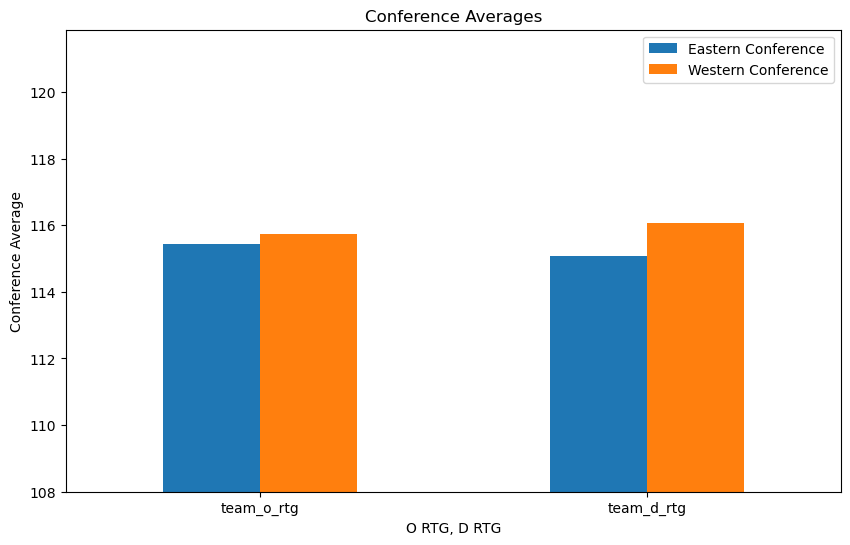

In [14]:
#visualizations
#offense and defense across conferences
# Create a new dataframe with only the columns of interest and the "conference average" rows
conf_averages = pd.concat([eastern_conf_df.loc['Conference average'], western_conf_df.loc['Conference average']], axis=1)
conf_averages.columns = ['Eastern Conference', 'Western Conference']
conf_average_ratings = conf_averages.loc[['team_o_rtg', 'team_d_rtg']]

# Create the bar chart
ax = conf_average_ratings.plot.bar(rot=0, figsize=(10, 6))
ax.set_xlabel('O RTG, D RTG')
ax.set_ylabel('Conference Average')
ax.set_title('Conference Averages')
ax.set_ylim(108, None)

plt.show()


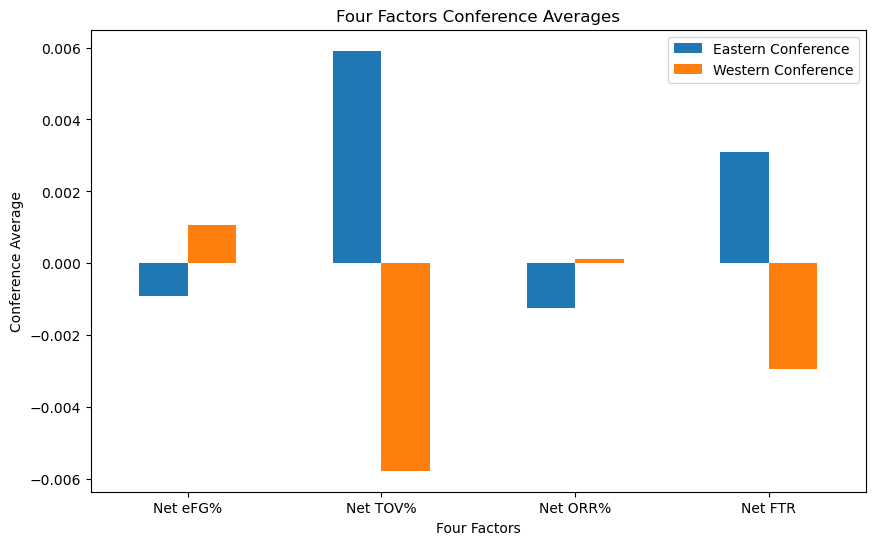

In [15]:
#4 factors across conferences
conf_average_factors = conf_averages.loc[['Net eFG%', 'Net TOV%', 'Net ORR%', 'Net FTR']]

# Create the bar chart
ax = conf_average_factors.plot.bar(rot=0, figsize=(10, 6))
ax.set_xlabel('Four Factors')
ax.set_ylabel('Conference Average')
ax.set_title('Four Factors Conference Averages')

plt.show()


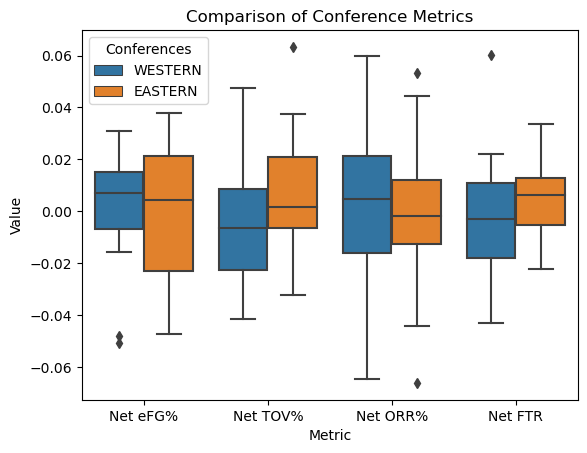

In [16]:
# four factors box and whiskers chart across conferences
conf_df = four_factors_df[['Conferences', 'Net eFG%', 'Net TOV%', 'Net ORR%', 'Net FTR', '3PR']]

conf_four_factors_df = pd.melt(conf_df, id_vars=['Conferences'], value_vars=['Net eFG%', 'Net TOV%', 'Net ORR%', 'Net FTR'])

# Create the box plot using matplotlib
fig, ax = plt.subplots()
sns.boxplot(x='variable', y='value', hue='Conferences', data=conf_four_factors_df, ax=ax)


ax.set_title('Comparison of Conference Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Show the plot
plt.show()

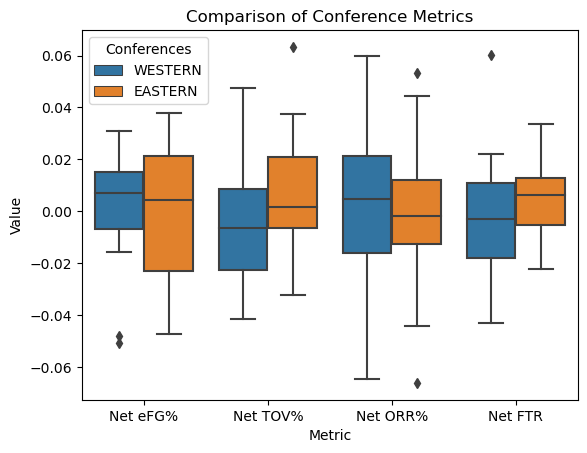

In [17]:
conf_3pr_df = pd.melt(conf_df, id_vars=['Conferences'], value_vars=['3PR'])
# Create the box plot using matplotlib
fig, ax = plt.subplots()
sns.boxplot(x='variable', y='value', hue='Conferences', data=conf_four_factors_df, ax=ax)


ax.set_title('Comparison of Conference Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Show the plot
plt.show()

The r-values is: 0.9554875367597743


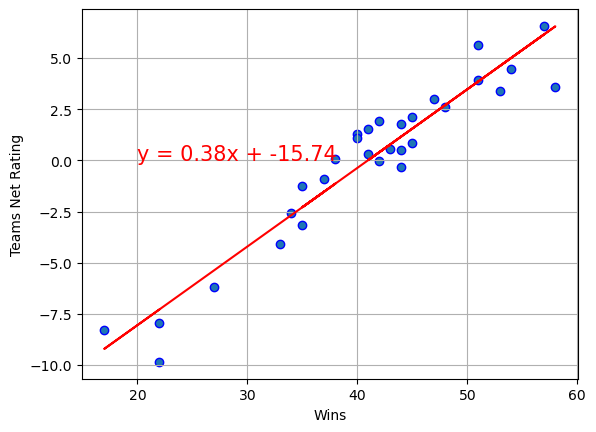

In [18]:
#wins vs net rating
plt.scatter(last_team_df["Wins"], last_team_df["team_net_rtg"], edgecolor="Blue", alpha=1)

plt.xlabel("Wins")
plt.ylabel("Teams Net Rating")


plt.grid(True)
x_values=last_team_df["Wins"]
y_values=last_team_df["team_net_rtg"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
r_values= x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,r_values,"r-")
plt.annotate(line_eq,(20,0),fontsize=15,color="red")
print("The r-values is: "+ str(rvalue))
plt.show()

The r-values is: 0.785660407307881


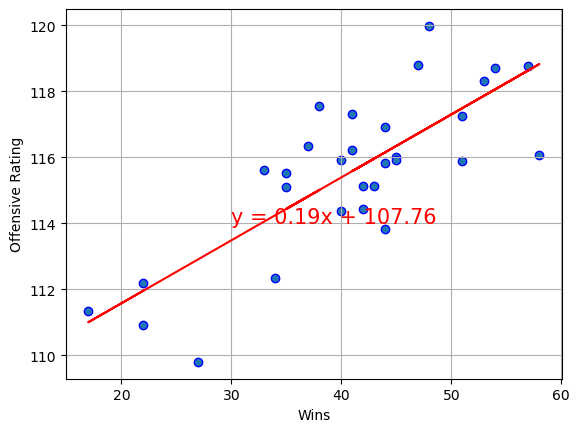

In [19]:
#wins vs offense
plt.scatter(last_team_df["Wins"], last_team_df["team_o_rtg"], edgecolor="Blue", alpha=1)

plt.xlabel("Wins")
plt.ylabel("Offensive Rating")


plt.grid(True)
x_values=last_team_df["Wins"]
y_values=last_team_df["team_o_rtg"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
r_values= x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,r_values,"r-")
plt.annotate(line_eq,(30,114),fontsize=15,color="red")
print("The r-values is: "+ str(rvalue))
plt.show()

The r-values is: 0.1678423540997648


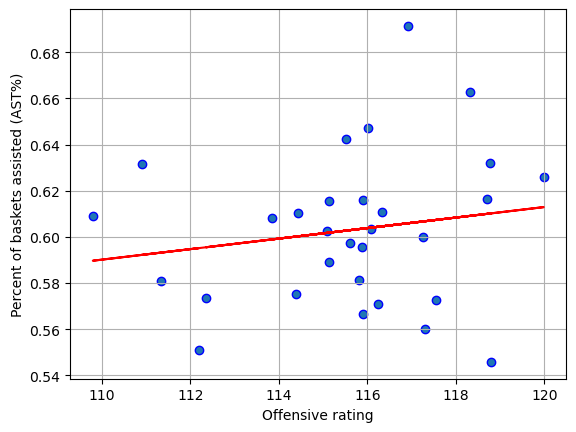

In [20]:
#AST% vs offense
plt.scatter(last_team_df["team_o_rtg"], last_team_df["AST%"], edgecolor="Blue", alpha=1)

plt.xlabel("Offensive rating")
plt.ylabel("Percent of baskets assisted (AST%)")


plt.grid(True)
x_values=last_team_df["team_o_rtg"]
y_values=last_team_df["AST%"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
r_values= x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,r_values,"r-")
plt.annotate(line_eq,(30,114),fontsize=15,color="red")
print("The r-values is: "+ str(rvalue))
plt.show()

The r-values is: 0.3113353793201417


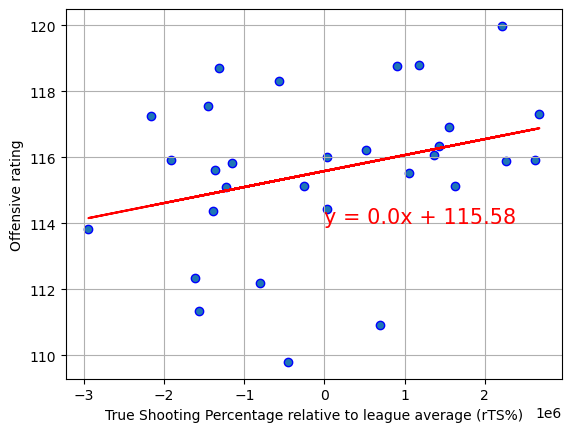

In [21]:
#rTS% vs. offense
plt.scatter(last_team_df["rTS%"], last_team_df["team_o_rtg"], edgecolor="Blue", alpha=1)

plt.xlabel("True Shooting Percentage relative to league average (rTS%)")
plt.ylabel("Offensive rating")


plt.grid(True)
x_values=last_team_df["rTS%"]
y_values=last_team_df["team_o_rtg"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
r_values= x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,r_values,"r-")
plt.annotate(line_eq,(30,114),fontsize=15,color="red")
print("The r-values is: "+ str(rvalue))
plt.show()

The r-values is: 0.34758934756232734


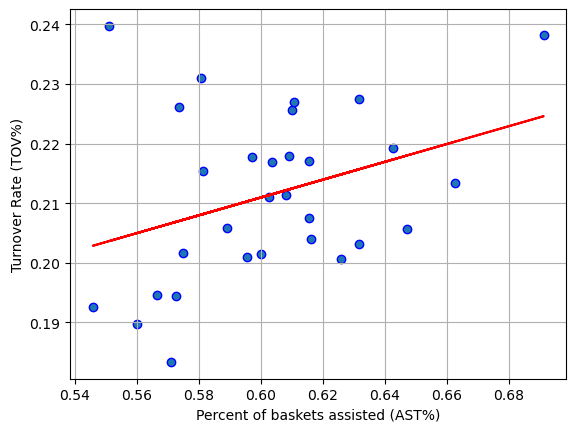

In [22]:
#AST% vs TOV%
plt.scatter(last_team_df["AST%"], four_factors_df["Team TOV%"], edgecolor="Blue", alpha=1)

plt.xlabel("Percent of baskets assisted (AST%)")
plt.ylabel("Turnover Rate (TOV%)")


plt.grid(True)
x_values=last_team_df["AST%"]
y_values=four_factors_df["Team TOV%"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
r_values= x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,r_values,"r-")
plt.annotate(line_eq,(30,114),fontsize=15,color="red")
print("The r-values is: "+ str(rvalue))
plt.show()

The r-values is: -0.7864739382505491


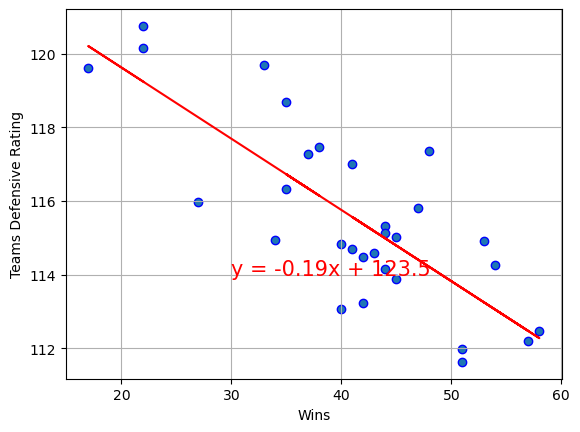

In [23]:
#wins vs defense
plt.scatter(last_team_df["Wins"], last_team_df["team_d_rtg"], edgecolor="Blue", alpha=1)

plt.xlabel("Wins")
plt.ylabel("Teams Defensive Rating")


plt.grid(True)
x_values=last_team_df["Wins"]
y_values=last_team_df["team_d_rtg"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
r_values= x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,r_values,"r-")
plt.annotate(line_eq,(30,114),fontsize=15,color="red")
print("The r-values is: "+ str(rvalue))
plt.show()

r value: 0.9298665055415285


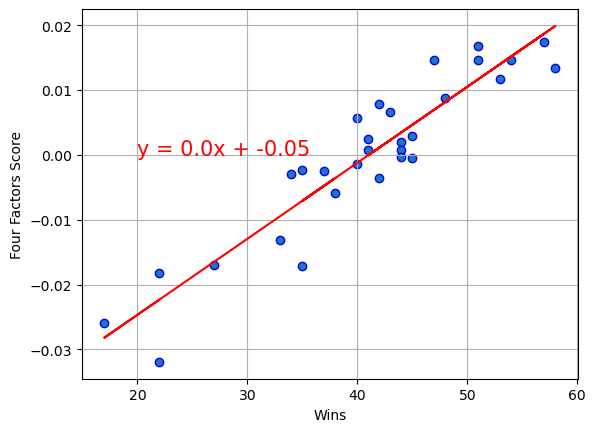

In [24]:
#four factors vs wins
plt.scatter(four_factors_df["Wins"], four_factors_df['Four Factors Score'], edgecolor="Blue", alpha=1)

plt.xlabel('Wins')
plt.ylabel('Four Factors Score')


plt.grid(True)
x_values=four_factors_df['Wins']
y_values=four_factors_df['Four Factors Score']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
r_values= x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,r_values,"r-")
plt.annotate(line_eq,(20,0),fontsize=15,color="red")
print(f'r value: {rvalue}')

plt.show()

r value: 0.5383193176753208


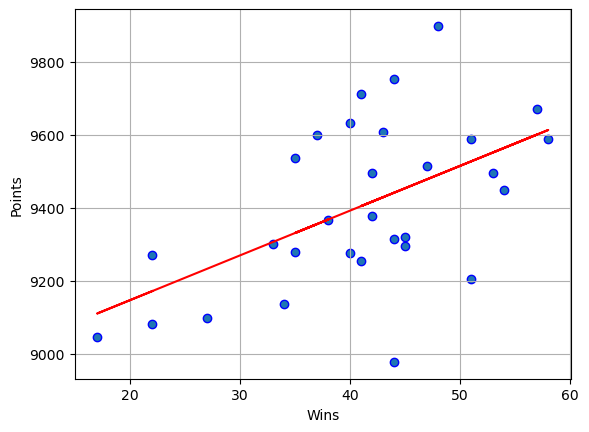

In [25]:
#points vs wins
plt.scatter(four_factors_df['Wins'], last_team_df['Team Points'], edgecolor='Blue', alpha=1)

plt.xlabel('Wins')
plt.ylabel('Points')


plt.grid(True)
x_values=four_factors_df['Wins']
y_values=last_team_df['Team Points']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
r_values= x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,r_values,"r-")
plt.annotate(line_eq,(20,0),fontsize=15,color="red")
print(f'r value: {rvalue}')

plt.show()

r value: 0.9549520774958093


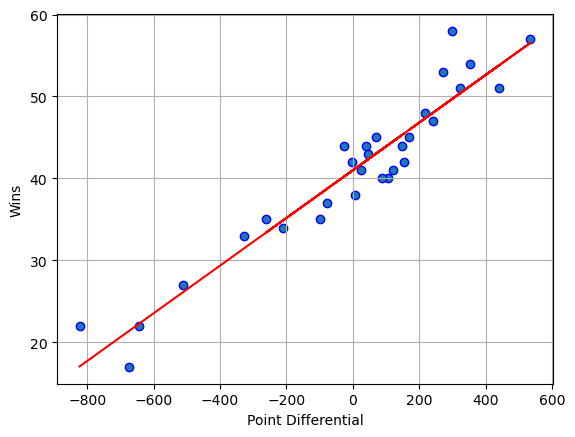

In [26]:
#point differential vs wins
plt.scatter(last_team_df['Point Differential'], four_factors_df['Wins'], edgecolor='Blue', alpha=1)

plt.xlabel('Point Differential')
plt.ylabel('Wins')


plt.grid(True)
x_values=last_team_df['Point Differential']
y_values=four_factors_df['Wins']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
r_values= x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,r_values,"r-")
plt.annotate(line_eq,(20,0),fontsize=15,color="red")
print(f'r value: {rvalue}')

plt.show()

r value: 0.9554875367597743


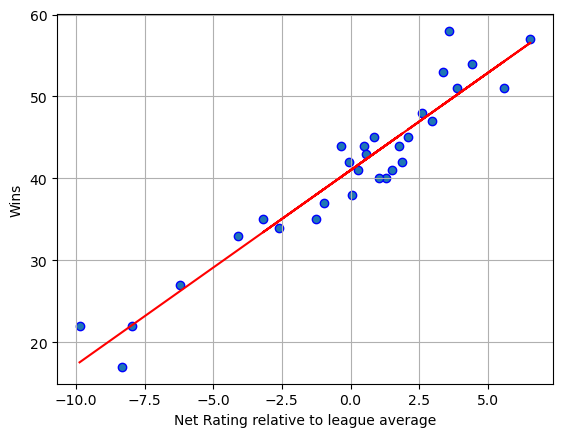

In [27]:
#rNet Rtg vs wins
plt.scatter(last_team_df['rNet Rtg'], four_factors_df['Wins'], edgecolor='Blue', alpha=1)

plt.xlabel('Net Rating relative to league average')
plt.ylabel('Wins')


plt.grid(True)
x_values=last_team_df['rNet Rtg']
y_values=four_factors_df['Wins']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
r_values= x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,r_values,"r-")
plt.annotate(line_eq,(20,0),fontsize=15,color="red")
print(f'r value: {rvalue}')

plt.show()
